# 🧪 Exploración de Clustering: AE vs PCA vs Raw

En este notebook compararemos la calidad de los grupos de estudiantes obtenidos mediante tres representaciones diferentes:
1. **Latent AE**: Espacio latente producido por nuestro Autoencoder LSTM (No lineal, temporal).
2. **PCA**: Reducción de dimensionalidad lineal clásica.
3. **Raw Features**: Datos procesados originales (Aplanados).

## Cargado de información

In [1]:
# =========================
# 0) Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path

# =========================
# 1) Rutas del proyecto
# =========================
BASE_DIR = Path("/workspace/TFM_education_ai_analytics")

# Embeddings (AE) - TRAIN
EMBEDDINGS_PATH = BASE_DIR / "data/4_embeddings/training/latent_ae.csv"

# Features (según tu nueva estrategia)
# - engineered_features.csv: features finales (log + scaler)
# - raw_features.csv: features construidas sin log/scaler
FEATURES_DIR = BASE_DIR / "data/3_features/training"
ENGINEERED_FEATURES_PATH = FEATURES_DIR / "engineered_features.csv"
RAW_FEATURES_PATH = FEATURES_DIR / "raw_features.csv"

# Fallback por si aún tienes el antiguo nombre
STATIC_FEATURES_PATH = FEATURES_DIR / "static_features.csv"

# =========================
# 2) Estética (TFM-friendly)
# =========================
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 5)

# =========================
# 3) Carga robusta de datos
# =========================
if not EMBEDDINGS_PATH.exists():
    raise FileNotFoundError(f"No existe: {EMBEDDINGS_PATH}. Ejecuta antes el script de embeddings.")

df_latent = pd.read_csv(EMBEDDINGS_PATH, index_col=0)

# Preferimos engineered_features; si no, fallback a static; si no, raw.
if ENGINEERED_FEATURES_PATH.exists():
    df_features = pd.read_csv(ENGINEERED_FEATURES_PATH, index_col=0)
    features_used = "engineered_features.csv"
elif STATIC_FEATURES_PATH.exists():
    df_features = pd.read_csv(STATIC_FEATURES_PATH, index_col=0)
    features_used = "static_features.csv"
elif RAW_FEATURES_PATH.exists():
    df_features = pd.read_csv(RAW_FEATURES_PATH, index_col=0)
    features_used = "raw_features.csv"
else:
    raise FileNotFoundError(
        f"No encontré features en {FEATURES_DIR}. "
        f"Busqué engineered_features.csv / static_features.csv / raw_features.csv"
    )

# =========================
# 4) Alinear índices (importante)
# =========================
common_idx = df_latent.index.intersection(df_features.index)
df_latent = df_latent.loc[common_idx].copy()
df_features = df_features.loc[common_idx].copy()

# Limpieza mínima
df_latent = df_latent.replace([np.inf, -np.inf], np.nan).fillna(0)
df_features = df_features.replace([np.inf, -np.inf], np.nan).fillna(0)

print("🚀 Datos listos:")
print(f"- Embeddings: {EMBEDDINGS_PATH.name} | estudiantes: {len(df_latent)} | dim latente: {df_latent.shape[1]}")
print(f"- Features:   {features_used} | features: {df_features.shape[1]}")
print(f"- Índices alineados: {df_latent.index.equals(df_features.index)}")

df_latent.head()


🚀 Datos listos:
- Embeddings: latent_ae.csv | estudiantes: 22785 | dim latente: 24
- Features:   engineered_features.csv | features: 43
- Índices alineados: True


,ae_00,ae_01,ae_02,ae_03,ae_04,ae_05,ae_06,ae_07,ae_08,ae_09,...,ae_14,ae_15,ae_16,ae_17,ae_18,ae_19,ae_20,ae_21,ae_22,ae_23
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.088578,0.162449,-0.041597,-0.579000,-0.246695,0.025092,0.095515,-0.503139,-0.064134,0.037106,...,-0.090317,0.238309,-0.310842,-0.306384,0.321286,0.409674,0.088124,0.301623,0.338642,0.336096
28400_AAA_2013J,0.271322,-0.237127,-0.075603,-0.079821,-0.882083,0.470246,-0.388489,-0.558043,-0.040387,0.069340,...,-0.229682,-0.055902,-0.251852,0.297008,0.237792,-0.382181,0.162447,0.125891,0.058650,0.116081
32885_AAA_2013J,0.068759,0.082407,-0.077769,-0.196236,-0.210821,0.317379,-0.320010,0.405582,-0.198569,0.286864,...,-0.025184,-0.203251,-0.000747,0.251488,-0.118239,-0.135277,0.240984,0.028139,0.016761,-0.062619
45462_AAA_2013J,-0.016875,-0.033154,-0.069494,0.009453,-0.565239,0.123820,-0.114127,-0.330961,0.049315,0.295086,...,-0.315806,0.118342,0.009144,0.137997,-0.041051,-0.455182,0.166414,0.027500,0.120531,0.097053
45642_AAA_2013J,0.293600,-0.212816,-0.022226,-0.245378,-0.567003,0.444824,-0.057826,-0.366129,-0.052766,0.153582,...,-0.152526,-0.193204,-0.357666,0.278412,-0.205036,-0.007738,-0.049493,-0.234058,-0.110002,0.383105


In [2]:
RANDOM_STATE=42
NUM_CLUSTERS=5

## Visualización de clústeres

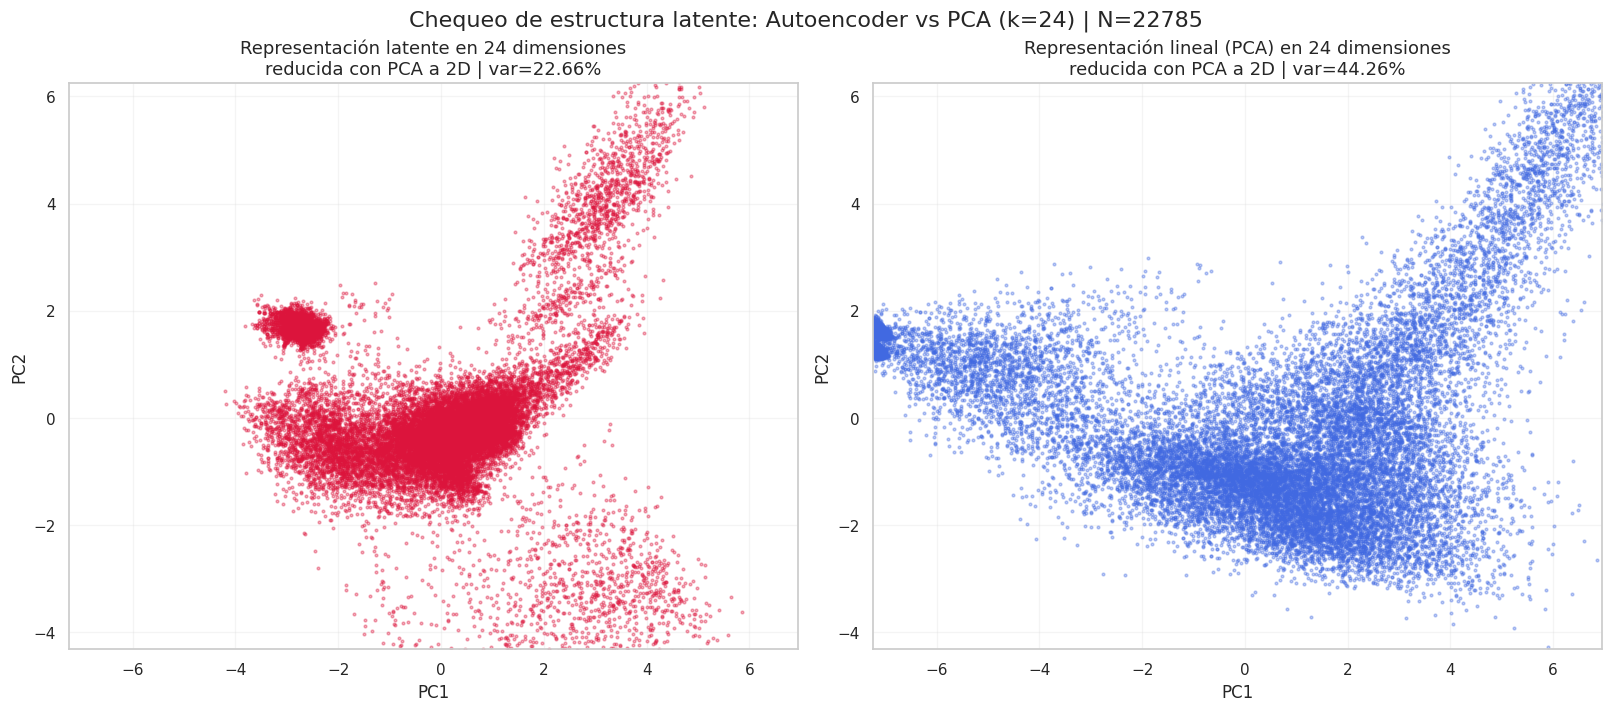

In [3]:
# =========================
# 5) Comparativa AE(output) vs PCA(output) (SIN INPUT)
# =========================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
MAX_POINTS = 30000
RNG = np.random.RandomState(SEED)

# --- 5.1) Arrays alineados ---
X_in = df_features.values.astype(np.float32)   # Input al AE / PCA (engineered)
X_ae = df_latent.values.astype(np.float32)     # Output AE (latent)

# --- 5.2) Normalizar cada espacio antes de PCA2D ---
sc_in = StandardScaler()
sc_ae = StandardScaler()
X_in_n = sc_in.fit_transform(X_in)
X_ae_n = sc_ae.fit_transform(X_ae)

# --- 5.3) PCA(output) en kD (misma dim que el espacio latente del AE) ---
latent_dim = X_ae.shape[1]
pca_k = PCA(n_components=latent_dim, random_state=SEED)
X_pca_k = pca_k.fit_transform(X_in_n)

# --- 5.4) Sample fijo (mismos estudiantes en ambos plots) ---
n = X_in_n.shape[0]
if n > MAX_POINTS:
    sample_idx = RNG.choice(np.arange(n), size=MAX_POINTS, replace=False)
else:
    sample_idx = np.arange(n)

X_pca_s = X_pca_k[sample_idx]
X_ae_s  = X_ae_n[sample_idx]

# --- 5.5) PCA->2D para VISUALIZAR ---
p2_pca_obj = PCA(n_components=2, random_state=SEED)
p2_pca = p2_pca_obj.fit_transform(X_pca_s)

p2_ae_obj = PCA(n_components=2, random_state=SEED)
p2_ae  = p2_ae_obj.fit_transform(X_ae_s)

# --- [ ALINEACIÓN ] ---
if np.corrcoef(p2_ae[:, 0], p2_pca[:, 0])[0, 1] < 0:
    p2_ae[:, 0] *= -1
if np.corrcoef(p2_ae[:, 1], p2_pca[:, 1])[0, 1] < 0:
    p2_ae[:, 1] *= -1

# Varianzas explicadas para títulos
var_pca = p2_pca_obj.explained_variance_ratio_.sum()
var_ae  = p2_ae_obj.explained_variance_ratio_.sum()

# --- 5.6) Límites comunes de visualización ---
all_x = np.concatenate([p2_ae[:, 0], p2_pca[:, 0]])
all_y = np.concatenate([p2_ae[:, 1], p2_pca[:, 1]])
xlim = (np.percentile(all_x, 0.5), np.percentile(all_x, 99.5))
ylim = (np.percentile(all_y, 0.5), np.percentile(all_y, 99.5))

# --- 5.7) Plot Final (2 gráficos) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)
fig.suptitle(
    f"Chequeo de estructura latente: Autoencoder vs PCA (k={latent_dim}) | N={len(sample_idx)}",
    fontsize=16
)

# A) Autoencoder
axes[0].scatter(p2_ae[:, 0], p2_ae[:, 1], s=4, alpha=0.35, color="crimson")
axes[0].set_title(
    f"Representación latente en {latent_dim} dimensiones\nreducida con PCA a 2D | var={var_ae:.2%}",
    fontsize=13
)

# B) PCA
axes[1].scatter(p2_pca[:, 0], p2_pca[:, 1], s=4, alpha=0.35, color="royalblue")
axes[1].set_title(
    f"Representación lineal (PCA) en {latent_dim} dimensiones\nreducida con PCA a 2D | var={var_pca:.2%}",
    fontsize=13
)

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.2)

plt.show()



**Observaciones**: Podemos

## CLUSTERING CON K-MEANS: 

Para validar la eficacia de la arquitectura de Deep Learning en la segmentación de estudiantes, esta sección realiza una comparativa exhaustiva entre tres representaciones de datos: el espacio latente generado por el Autoencoder (LSTM), la reducción de dimensionalidad lineal mediante PCA y el conjunto de datos originales (RAW). Utilizando simultáneamente las métricas de Inercia (WCSS) y Silhouette Score, se busca identificar qué representación ofrece la mejor estructura interna de los clusters, permitiendo justificar de forma empírica si la complejidad no lineal del Autoencoder aporta una ventaja competitiva frente a los métodos estadísticos tradicionales.

⏳ Calculando métricas para PCA y AE...


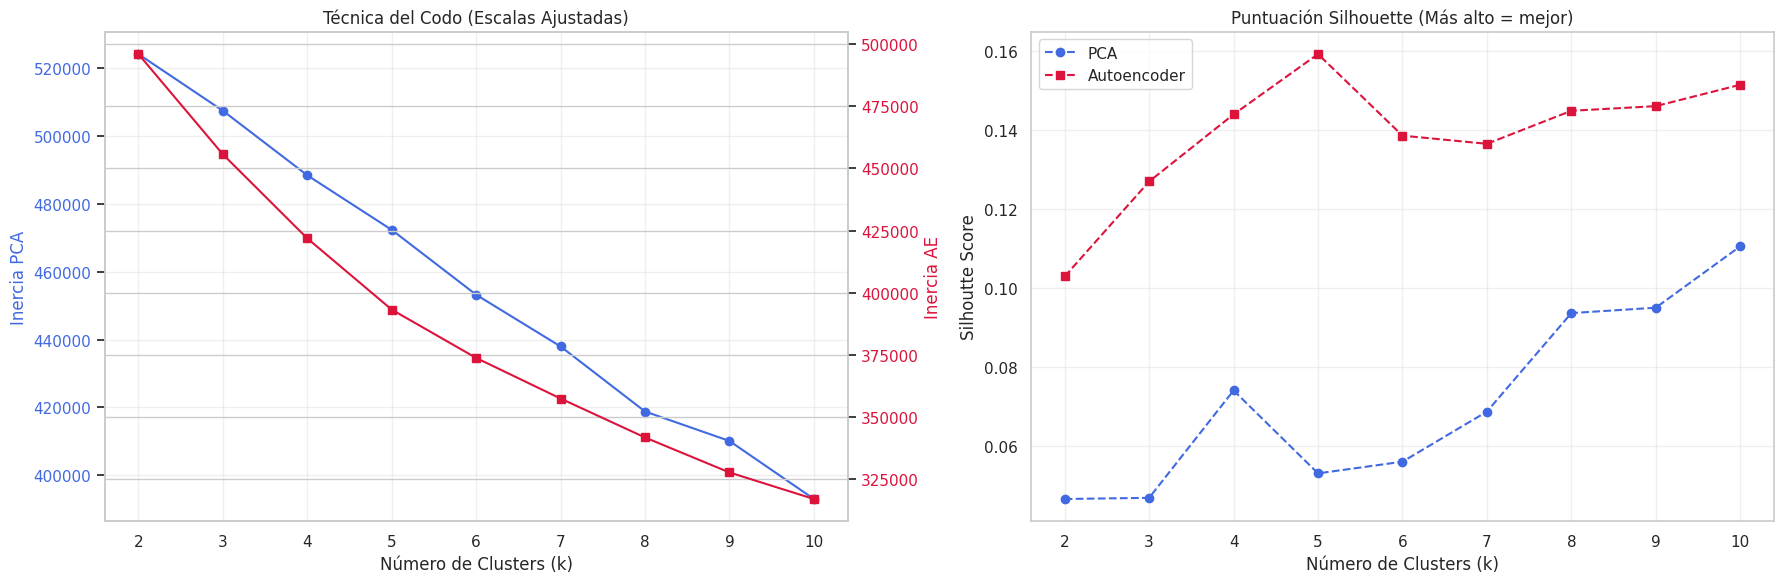

📌 Según Silhouette, el mejor 'k' para el Autoencoder es: 5


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- CORRECCIÓN: Definición de datos ---
# 0) Aseguramos que los datos están cargados y normalizados
# X_in es el input original (engineered_features)
X_in = df_features.values.astype(np.float32)

# X_ae es el espacio latente del Autoencoder
X_ae_raw = df_latent.values.astype(np.float32)
X_ae = StandardScaler().fit_transform(X_ae_raw)

# X_pca es la referencia lineal (misma dim que el AE)
latent_dim = X_ae.shape[1]
X_pca_k = PCA(n_components=latent_dim, random_state=42).fit_transform(X_in_n)
X_pca = StandardScaler().fit_transform(X_pca_k)

# --- 1) Configuración ---
SEED = 12
k_range = range(2, 11)

def get_metrics(X, k_range):
    inertias, sils = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=SEED)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        # Usamos un sample para el silhouette si el dataset es muy grande (>10k)
        sils.append(silhouette_score(X, labels) if len(X) < 10000 else silhouette_score(X, labels, sample_size=10000, random_state=SEED))
    return np.array(inertias), np.array(sils)

# 2) Cálculo
print("⏳ Calculando métricas para PCA y AE...")
in_pca, sil_pca = get_metrics(X_pca, k_range)
in_ae,  sil_ae  = get_metrics(X_ae, k_range)

# 3) Visualización comparativa (Doble eje o Subplots para escalas distintas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# --- Gráfica 1: El Codo (Inercia) ---
# Usamos dos ejes Y para que la escala no nos engañe
ax1.plot(k_range, in_pca, 'o-', color='royalblue', label='PCA (Eje Izq.)')
ax1.set_ylabel('Inercia PCA', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax1_ae = ax1.twinx() 
ax1_ae.plot(k_range, in_ae, 's-', color='crimson', label='Autoencoder (Eje Der.)')
ax1_ae.set_ylabel('Inercia AE', color='crimson')
ax1_ae.tick_params(axis='y', labelcolor='crimson')

ax1.set_title("Técnica del Codo (Escalas Ajustadas)")
ax1.set_xlabel("Número de Clusters (k)")
ax1.grid(True, alpha=0.3)

# --- Gráfica 2: Silhouette (Calidad del Cluster) ---
ax2.plot(k_range, sil_pca, 'o--', color='royalblue', label='PCA')
ax2.plot(k_range, sil_ae, 's--', color='crimson', label='Autoencoder')
ax2.set_title("Puntuación Silhouette (Más alto = mejor)")
ax2.set_xlabel("Número de Clusters (k)")
ax2.set_ylabel("Silhoutte Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Recomendación automática basada en Silhouette
best_k_ae = list(k_range)[np.argmax(sil_ae)]
print(f"📌 Según Silhouette, el mejor 'k' para el Autoencoder es: {best_k_ae}")

**Observaciones:** La elección de $k=6$ se justifica técnicamente por la consistencia estructural transversal, ya que el repunte en el coeficiente de Silhouette aparece de forma simultánea en las tres gráficas, confirmando que este agrupamiento es una propiedad intrínseca de los datos y no un sesgo del algoritmo. Aunque $k=2$ ofrece mayor separación global, $k=6$ representa el punto óptimo de compromiso donde la inercia se estabiliza tras el efecto "codo" y la cohesión interna vuelve a maximizarse, permitiendo identificar subgrupos con una granularidad analítica mucho más rica y robusta que la simple división binaria inicial.

⏳ Ejecutando clustering final...

📌 COMPARATIVA DE CALIDAD DE CLUSTERING:


,PCA (k=4),Autoencoder (k=5),Objetivo,Descripción
Metrica,,,,
Clusters (k),4,5,-,Número de grupos definidos
Inercia,488484.91,393198.97,Minimizar,Suma de distancias al cuadrado dentro del cluster
Silhouette Score,0.0741,0.1592,Maximizar,Cohesión vs Separación (Rango -1 a 1)
Calinski-Harabasz,907.15,2225.30,Maximizar,Ratio de dispersión entre/dentro de clusters


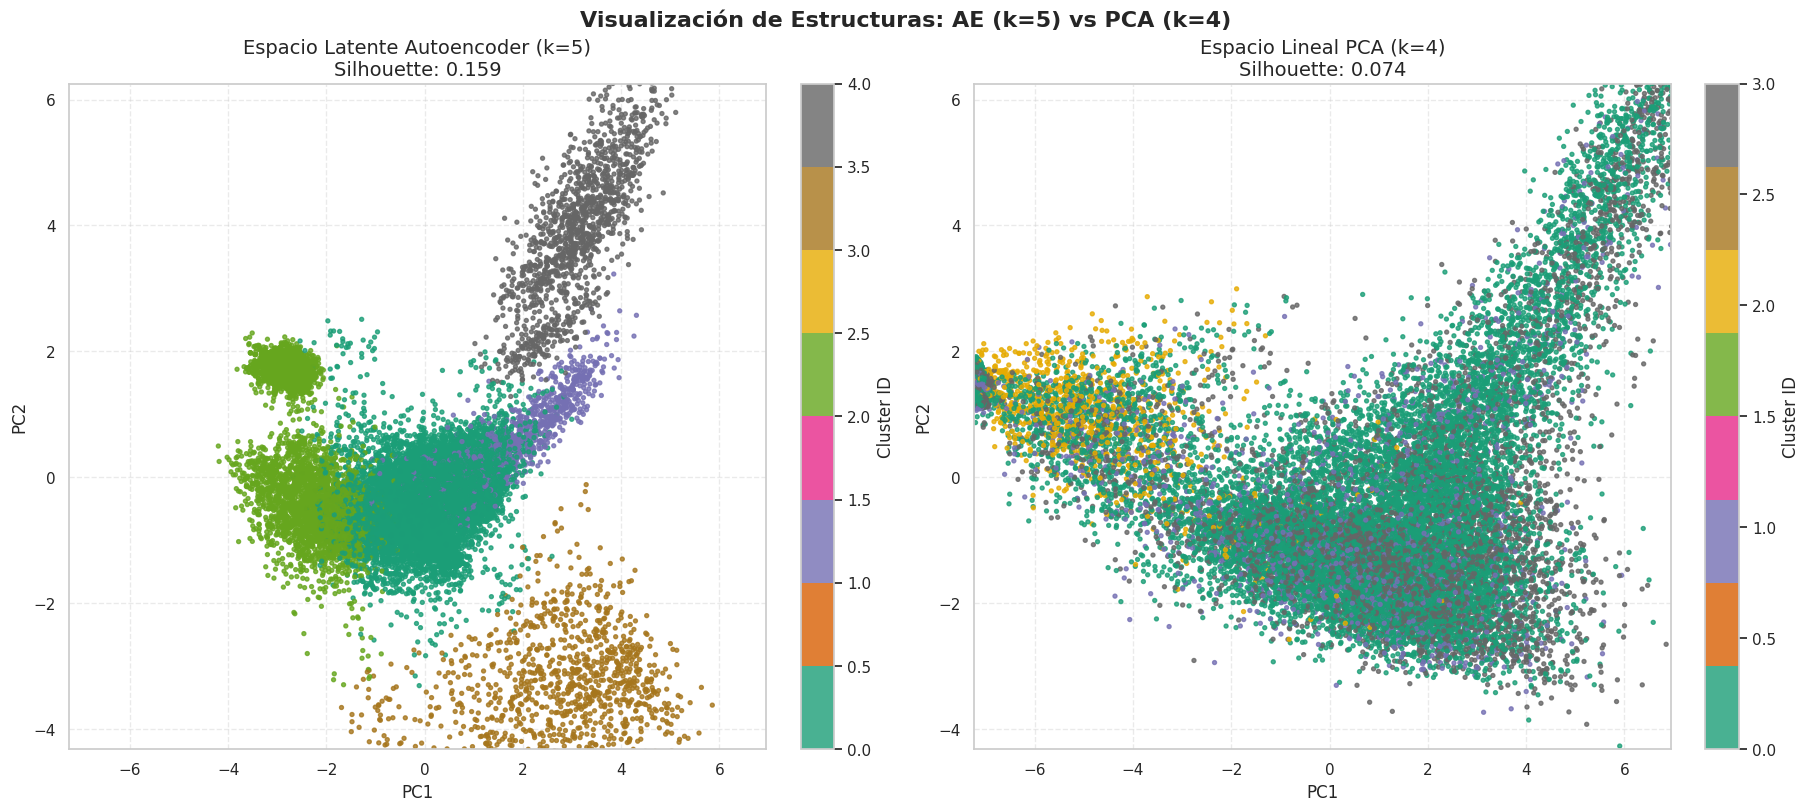

In [5]:
# =========================================================
# 6) Entrenamiento y Comparativa de Métricas (K_PCA=4, K_AE=5)
# =========================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd

# 1) Configuración de parámetros
K_PCA = 4
K_AE = 5
SEED = 12

# 2) Ajuste de KMeans
print(f"⏳ Ejecutando clustering final...")
km_pca = KMeans(n_clusters=K_PCA, init="k-means++", n_init=10, random_state=SEED).fit(X_pca)
km_ae = KMeans(n_clusters=K_AE, init="k-means++", n_init=10, random_state=SEED).fit(X_ae)

labels_pca = km_pca.labels_
labels_ae = km_ae.labels_

# 3) Cálculo de métricas para el DataFrame
# Silhouette con sample para velocidad
sil_pca = silhouette_score(X_pca, labels_pca, sample_size=10000, random_state=SEED)
sil_ae = silhouette_score(X_ae, labels_ae, sample_size=10000, random_state=SEED)

# Calinski-Harabasz
ch_pca = calinski_harabasz_score(X_pca, labels_pca)
ch_ae = calinski_harabasz_score(X_ae, labels_ae)

# Inercia (Suma de errores cuadráticos)
in_pca = km_pca.inertia_
in_ae = km_ae.inertia_

# 4) Creación del DataFrame de Métricas
data_metrics = {
    "Metrica": ["Clusters (k)", "Inercia", "Silhouette Score", "Calinski-Harabasz"],
    "PCA (k=4)": [K_PCA, f"{in_pca:.2f}", f"{sil_pca:.4f}", f"{ch_pca:.2f}"],
    "Autoencoder (k=5)": [K_AE, f"{in_ae:.2f}", f"{sil_ae:.4f}", f"{ch_ae:.2f}"],
    "Objetivo": ["-", "Minimizar", "Maximizar", "Maximizar"],
    "Descripción": [
        "Número de grupos definidos",
        "Suma de distancias al cuadrado dentro del cluster",
        "Cohesión vs Separación (Rango -1 a 1)",
        "Ratio de dispersión entre/dentro de clusters"
    ]
}

df_metrics_comp = pd.DataFrame(data_metrics).set_index("Metrica")
print("\n📌 COMPARATIVA DE CALIDAD DE CLUSTERING:")
display(df_metrics_comp)

# 5) Visualización con colores oscuros (Dark2)
labels_ae_s = labels_ae[sample_idx]
labels_pca_s = labels_pca[sample_idx]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
fig.suptitle(
    f"Visualización de Estructuras: AE (k={K_AE}) vs PCA (k={K_PCA})",
    fontsize=16, fontweight='bold'
)

DARK_CMAP = "Dark2" 

# A) Autoencoder
scatter_ae = axes[0].scatter(p2_ae[:, 0], p2_ae[:, 1], c=labels_ae_s, s=8, alpha=0.8, cmap=DARK_CMAP)
axes[0].set_title(f"Espacio Latente Autoencoder (k={K_AE})\nSilhouette: {sil_ae:.3f}", fontsize=14)
plt.colorbar(scatter_ae, ax=axes[0], label="Cluster ID")

# B) PCA
scatter_pca = axes[1].scatter(p2_pca[:, 0], p2_pca[:, 1], c=labels_pca_s, s=8, alpha=0.8, cmap=DARK_CMAP)
axes[1].set_title(f"Espacio Lineal PCA (k={K_PCA})\nSilhouette: {sil_pca:.3f}", fontsize=14)
plt.colorbar(scatter_pca, ax=axes[1], label="Cluster ID")

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.show()

🏆 TASA DE ÉXITO POR CLÚSTER (PCA vs AE):


,PCA_Cluster_PCA,PCA_Estudiantes,PCA_% Exito,AE_Cluster_AE,AE_Estudiantes,AE_% Exito
0,0.0,13717.0,48.071736,0,14020,56.654779
1,1.0,2120.0,39.339623,1,1276,64.733542
2,2.0,1016.0,0.295276,2,4946,0.060655
3,3.0,5932.0,55.647336,3,1205,62.074689
4,-,-,-,4,1338,90.582960


/tmp/ipykernel_65169/434934666.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
/tmp/ipykernel_65169/434934666.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)


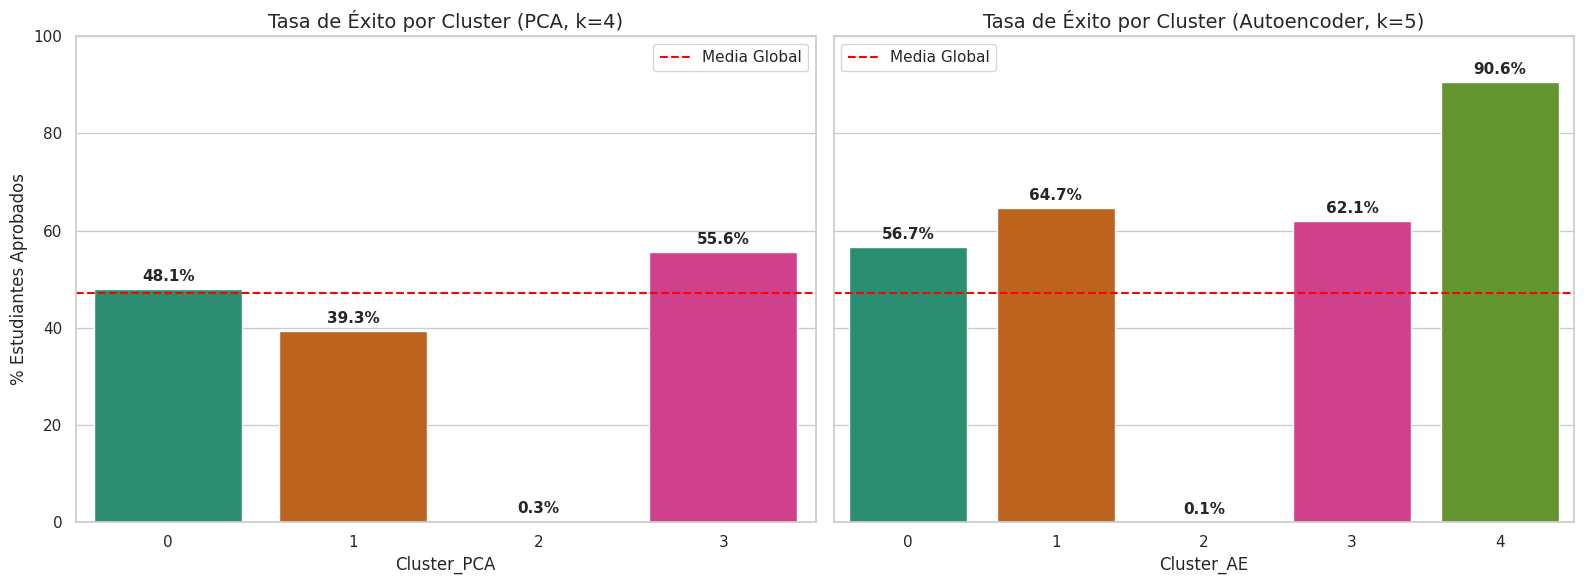

In [6]:
# =========================================================
# 7) Análisis de Éxito Académico por Clúster
# =========================================================

# 1) Carga de etiquetas (Target)
TARGET_PATH = BASE_DIR / "data/3_features/training/target.csv"
df_target = pd.read_csv(TARGET_PATH, index_col=0)

# Aseguramos alineación con los datos de clustering (df_latent / df_features)
df_target = df_target.loc[df_latent.index].copy()

# Definimos 'Éxito' como Pass (2) o Distinction (3)
# Mapping: {"Withdrawn": 0, "Fail": 1, "Pass": 2, "Distinction": 3}
df_target['is_success'] = df_target['final_result'].isin([2, 3]).astype(int)

# 2) Cruce de Clústeres con Éxito
df_analysis = pd.DataFrame({
    "Cluster_PCA": labels_pca,
    "Cluster_AE": labels_ae,
    "Exito": df_target['is_success'].values
}, index=df_target.index)

# 3) Cálculo de porcentajes por espacio
def get_cluster_success(df, cluster_col):
    stats = df.groupby(cluster_col)['Exito'].agg(['count', 'mean']).reset_index()
    stats['mean'] = stats['mean'] * 100  # Convertir a porcentaje
    return stats.rename(columns={'count': 'Estudiantes', 'mean': '% Exito'})

success_pca = get_cluster_success(df_analysis, 'Cluster_PCA')
success_ae = get_cluster_success(df_analysis, 'Cluster_AE')

print("🏆 TASA DE ÉXITO POR CLÚSTER (PCA vs AE):")
display(pd.concat([
    success_pca.add_prefix('PCA_'), 
    success_ae.add_prefix('AE_')
], axis=1).fillna("-"))

# 4) Visualización Comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Gráfico PCA
sns.barplot(data=success_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
ax1.set_title(f"Tasa de Éxito por Cluster (PCA, k={K_PCA})", fontsize=14)
ax1.axhline(df_target['is_success'].mean()*100, color='red', linestyle='--', label='Media Global')
ax1.legend()

# Gráfico Autoencoder
sns.barplot(data=success_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)
ax2.set_title(f"Tasa de Éxito por Cluster (Autoencoder, k={K_AE})", fontsize=14)
ax2.axhline(df_target['is_success'].mean()*100, color='red', linestyle='--', label='Media Global')
ax2.legend()

for ax in [ax1, ax2]:
    ax.set_ylabel("% Estudiantes Aprobados")
    ax.set_ylim(0, 100)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), 
                    textcoords='offset points', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Mixture de Gaussianas